# Automatic Essay Scoring (AES)

**Autores:** Karolayne Teixeira da Silva e Tiago Barbosa de Lima

*Link para o respositório* [aqui](https://github.com/Tiagoblima/explanaible-essay-grading).

Automatic Essay Scoring (AES) é uma tarefa de machine learning que consistem em atribuir uma nota para redação de maneira automática.
No geral, diversas abordagens na literatura apresentaram resultados significativos na tentativa de realizar esse processo utilizando diversas técnicas e algoritmos focando em diferentes aspectos como analise da corretude gramatical, existência de estrutura retórica entre outras.

Essencialmente, AES consiste em duas principais abordagens, a primeira usa regressão para atribuir uma nota ao texto de entrada, enquanto a segunda tenta classificar a nota em um intervalo predeterminado e fixo, por exemplo, (e.g 0, 50, 100, 150, 200) . Além disso,  podemos ainda dividir as notas por rubricas, aspectos especificos do texto que são avaliados como, por exemplo, apenas a gramatica, ou apenas a argumentação do texto etc.

Nesse contexto, a correção automática de redações do ENEM, por exemplo, tem sido tema de diversos artigos da área que empregam uma diversidade de técnicas com esse fim. Um dos objetivos para isso é a redução do tempo de correção e do custo operacional para isso. Assim, várias artigos, diversas técnicas foram empregadas, tanto aquelas que buscam uma classificação holistica (classificação da nota final) como aquelas que buscam uma classificação por rúbrica (classificação de um aspecto especifico).


Dessa maneira, nesse trabalho, para fins de simplicidade, iremos aplicar técnicas de classificação da nota final de redações do enem. Utilizaremos para isso o conjunto de dados de redações do UOL que contém 4570 redações em diferentes assuntos. Para atribuir uma nota, iremos utilizar um conjunto de classificadores extraindo diversas características relacionadas as aspectos como legibilidade, coesão, coerência e outros para assim classificar a nota entre 0, 50, 100, 150 e 200.



In [ ]:
!pip install -q aibox-nlp[all] imblearn lime shap

In [3]:
import nltk
nltk.download('punkt')
nltk.download('stopwords')

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from aibox.nlp.data.datasets import DatasetEssayBR
from sklearn.preprocessing import StandardScaler
from sklearn.tree import DecisionTreeClassifier
from aibox.nlp.data.datasets import DatasetDF
from aibox.nlp.factory import get_extractor
from imblearn.over_sampling import SMOTE
from collections import defaultdict
import lime.lime_tabular as lime_tb
from nltk.corpus import stopwords
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.svm import SVC
from sklearn import metrics
from lime import lime_text
from sklearn import tree
import seaborn as sns
from tqdm import tqdm
import pandas as pd
import numpy as np
import glob
import json
import lime

[nltk_data] Downloading package punkt to /home/jovyan/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to /home/jovyan/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


## Preparando o conjunto os Dados 

Como abordado em diversos artigos, uma forma de realizar a classificação de redação é usando extração de características do texto. Usamos a biblioteca aibox-nlp para realizar a extração das características do texto, ao total foram 144 relacionadas a características do texto como oração por sentença, adverbios antes do verbio principal e etc. Além disso, os dados foram normalização usando z-score scaling. A normalização normal com z-score faz com que todas as features tenha uma média centrada em zero e desvio padrão em 1, o que tem um impacto significativo na performance de modelos como KNN e LogisticRegression.
As features foram extraídas em um arquivo .csv devido ao longo tempo de processamento requirido para extrair todas elas. Os dados foram dividos em 80% em treinamento e 20% em teste, usamos Syntetic Minority Oversampling Technique (SMOTE) para aumentar a classe minoritária e evitar vieses.
Por fim, dividimos todas as notas em 5 categorias: 

| classe | Original | Agrupada |
|:------:|:--------:|:--------:|
|    1   |   0-200  |     0    |
|    2   |  200-400 |    0.5   |
|    3   |  400-600 |     1    |
|    4   |  600-800 |    1.5   |
|    5   | 800-1000 |     2    |

Como apresentado no artigo [Imbalanced Learning Techniques for Improving the Performance of Statistical Models in Automated Essay Scoring](https://www.sciencedirect.com/science/article/pii/S187705091931422X?via%3Dihub) e no conjunto de [redações do uol](https://github.com/gpassero/uol-redacoes-xml).


### Análise Exploratória dos Dados 


Carregaremos os dados a partir da biblioteca aibox-nlp

In [4]:
ds = DatasetEssayBR(extended=True, target_competence='score')
df = ds.to_frame()

print(f"Número total de redações: {len(df)}")

Número total de redações: 6564


Converter para o Formato da AIBoxLab

In [5]:
# Remover duplicados com base no texto
df = df.drop_duplicates(subset='text')

# Considerando que queremos prever a 'target'
# Vamos também remover redações sem nota
df = df.dropna(subset=['target', 'text'])

# Criar o dataset da AIBoxLab
dataset = DatasetDF(df, text_column='text', target_column='target')

Distribuição de Redações por Nota Final

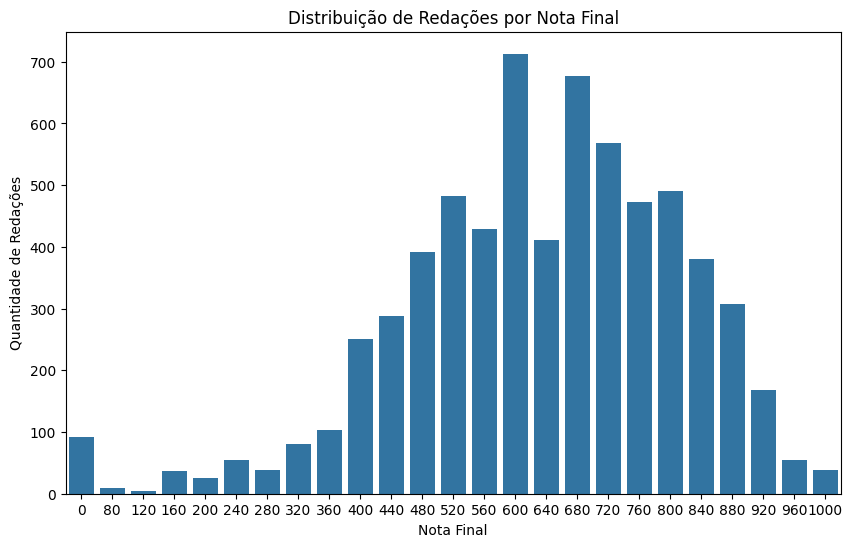

In [6]:
def plot_distribution_by_score(df):
    plt.figure(figsize=(10,6))
    sns.countplot(x='target', data=df)
    plt.title('Distribuição de Redações por Nota Final')
    plt.xlabel('Nota Final')
    plt.ylabel('Quantidade de Redações')
    plt.show()
plot_distribution_by_score(df)

Redações abaixo da nota 500

In [7]:
stop_words = set(stopwords.words('portuguese'))

def get_top_words(texts, n=20):
    all_words = ' '.join(texts).split()
    all_words = [word for word in all_words if word not in stop_words and len(word)>3]
    counter = Counter(all_words)
    return counter.most_common(n)

def plot_top_words(top_words, title):
    words, counts = zip(*top_words)
    plt.figure(figsize=(10,6))
    sns.barplot(x=list(counts), y=list(words))
    plt.title(title)
    plt.xlabel('Frequência')
    plt.ylabel('Palavras')
    plt.show()

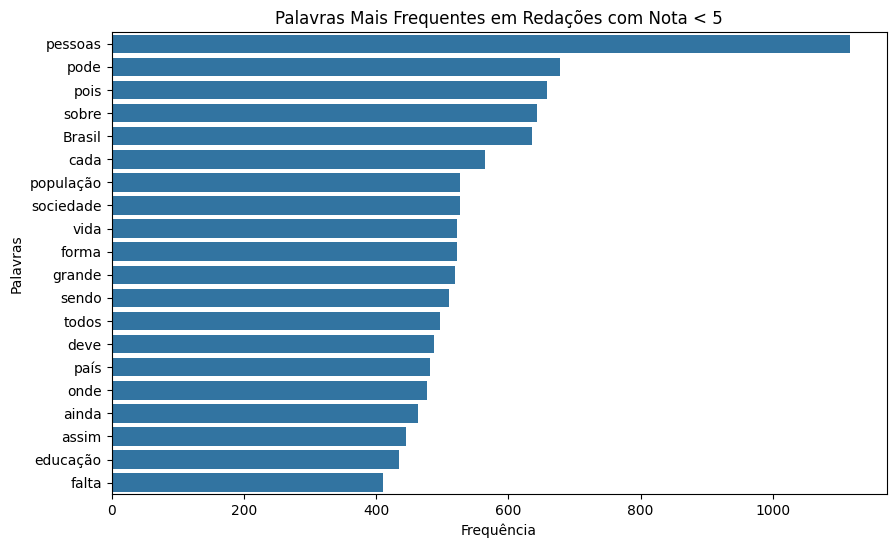

In [8]:
texts_below_5 = df[df['target'] < 500]['text']
top_words_below_5 = get_top_words(texts_below_5)

plot_top_words(top_words_below_5, 'Palavras Mais Frequentes em Redações com Nota < 5')

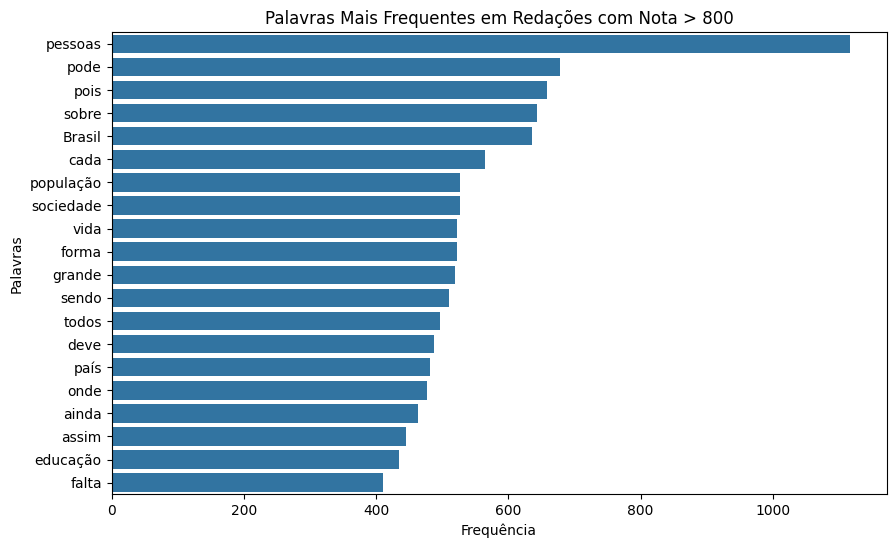

In [9]:
texts_above_8 = df[df['target'] > 800]['text']
top_words_above_8 = get_top_words(texts_above_8)

plot_top_words(top_words_below_5, 'Palavras Mais Frequentes em Redações com Nota > 800')

Média de Palavras em Redações com Nota < 5 e >= 5

In [10]:
df['word_count'] = df['text'].apply(lambda x: len(x.split()))

# Média de palavras
mean_words_below_5 = df[df['target'] < 500]['word_count'].mean()
mean_words_above_5 = df[df['target'] >= 500]['word_count'].mean()

print(f"Média de palavras em redações com nota < 5: {mean_words_below_5:.2f}")
print(f"Média de palavras em redações com nota >= 5: {mean_words_above_5:.2f}")


Média de palavras em redações com nota < 5: 229.94
Média de palavras em redações com nota >= 5: 305.46


Histograma do Número de Palavras

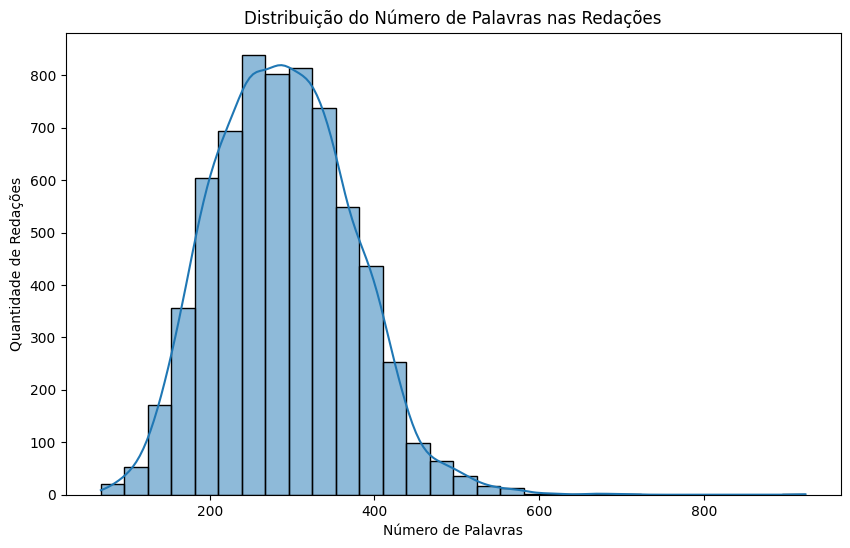

In [11]:
plt.figure(figsize=(10,6))
sns.histplot(data=df, x='word_count', bins=30, kde=True)
plt.title('Distribuição do Número de Palavras nas Redações')
plt.xlabel('Número de Palavras')
plt.ylabel('Quantidade de Redações')
plt.show()

### Extração De Features

A extração de features consiste em capturar informações estruturadas a partir de textos que ajudam a compreender suas propriedades linguísticas e semânticas. Essas features são importantes porque permitem que modelos de machine learning ou algoritmos de avaliação possam tomar decisões baseadas em atributos linguísticos específicos, melhorando a capacidade de previsão e interpretação do modelo.

Aqui está uma explicação sobre cada feature escolhida:

- CohmetrixBR: Mede a coesão do texto, que é a forma como as ideias e partes do texto estão conectadas. A coesão é importante porque textos bem conectados são mais fáceis de ler e entender, o que impacta diretamente a fluidez e clareza do conteúdo.

- LexicalDiversityBR: Refere-se à variedade de palavras usadas no texto. Quanto maior a diversidade lexical, maior o número de palavras distintas. Essa feature é importante para medir a riqueza do vocabulário, o que pode estar ligado à qualidade do texto ou à capacidade do autor de variar sua expressão.

- SyntacticComplexityBR: Avalia a complexidade das estruturas gramaticais usadas no texto, como o comprimento das frases e o uso de construções complexas. Essa feature é fundamental para entender a sofisticação sintática do autor e pode ser um indicador de maior maturidade linguística.

- ReadabilityBR: Mede a facilidade com que o texto pode ser lido e compreendido, levando em conta fatores como o comprimento das palavras e das frases. A legibilidade é importante, pois influencia o quão acessível um texto é para o leitor médio.

- SemanticCohesionBR: Avalia a coesão semântica, ou seja, a consistência de significado entre diferentes partes do texto. Textos com alta coesão semântica são mais fáceis de seguir e entender, pois mantêm uma ideia central clara.

- TextualSimplicityBR: Refere-se à simplicidade do texto em termos de estrutura e vocabulário. Textos simples geralmente são mais diretos e fáceis de interpretar, o que pode ser desejável dependendo do público-alvo.

In [ ]:
features_br = ["cohmetrixBR",
               "lexicalDiversityBR",
               "syntacticComplexityBR",
               "readabilityBR",
               "semanticCohesionBR",
               "textualSimplicityBR"
               ]

feature_extractor = get_extractor(features_br)

In [175]:
text_example = "O poeta modernista Oswald de Andrade relata, em \"Erro de Português\", que, sob um dia de chuva, o índio foi vestido pelo português - uma denúncia à aculturação sofrida pelos povos indígenas com a chegada dos europeus ao território brasileiro. Paralelamente, no Brasil atual, há a manutenção de práticas prejudiciais não só aos silvícolas, mas também aos demais povos e comunidades tradicionais, como os pescadores. Com efeito, atuam como desafios para a valorização desses grupos a educação deficiente acerca do tema e a ausência do desenvolvimento sustentável."

extraction = feature_extractor.extract(text_example)
print(json.dumps(extraction.as_dict(), indent=2, ensure_ascii=False))

{
  "adapted_dalechall": 5.09875968992248,
  "adverbs_before_main_verb_ratio": 0.16666666666666666,
  "brunet_indice": 9.066469756208491,
  "clauses_per_sentence": 2.0,
  "cncadc": 1.0,
  "cncadd": 4.0,
  "cncall": 3.0,
  "cncalter": 0.0,
  "cnccaus": 0.0,
  "cnccomp": 1.0,
  "cncconce": 1.0,
  "cncconclu": 0.0,
  "cnccondi": 0.0,
  "cncconfor": 2.0,
  "cncconse": 1.0,
  "cncexpli": 1.0,
  "cncfinal": 1.0,
  "cncinte": 1.0,
  "cnclogic": 3.0,
  "cncneg": 2.0,
  "cncpos": 17.0,
  "cncprop": 0.0,
  "cnctemp": 0.0,
  "coord_conj_ratio": 1.0,
  "coordinate_conjunctions_per_clauses": 0.5,
  "crfao1": 1.0,
  "crfaoa": 1.0,
  "crfcwo1": 0.05499181669394435,
  "crfcwo1d": 0.008837970540098196,
  "crfcwoa": 0.04203755521531774,
  "crfcwoad": 0.019690071857622927,
  "crfno1": 1.0,
  "crfnoa": 1.0,
  "crfso1": 1.0,
  "crfsoa": 1.0,
  "cross_entropy": 0.5307765240131274,
  "despc": 1.0,
  "despc2": 1.0,
  "despl": 3.0,
  "despld": 0.0,
  "dessc": 3.0,
  "dessl": 29.333333333333332,
  "dessld": 8.3

Extrair features por batch

O código realiza a extração de features de um conjunto de textos em batches para otimizar o tempo de processamento, já que o tempo de processamento é grande. A cada iteração, ele processa um batch de 1000 textos, aplicando a função de extração de features a cada um deles. O resultado de cada batch é salvo em um arquivo CSV separado.

In [ ]:
batch_size = 1000
num_batches = int(np.ceil(len(df) / batch_size))

batches = np.array_split(df, num_batches)

start_batch = 0

for i in range(start_batch, num_batches):
    batch = batches[i]
    print(f"Processando batch {i + 1}/{num_batches}")

    extraction = [features.as_dict() for features in tqdm(map(feature_extractor.extract, batch["text"]), total=len(batch["text"]))]

    X = extraction
    y = batch.target

    y_df = y.reset_index(drop=True)
    X_df = pd.DataFrame(X).reset_index(drop=True)

    y_df = y_df.rename("target")

    complete_df = pd.concat([X_df, y_df], axis=1)

    complete_df.to_csv(f"batch_{i + 1}.csv", index=False)

In [ ]:
batch_files_pattern = 'batch_*.csv'
batch_files = glob.glob(batch_files_pattern)

batch_dfs = []

for batch_file in batch_files:
    df = pd.read_csv(batch_file)
    batch_dfs.append(df)

concatenated_df = pd.concat(batch_dfs, ignore_index=True)

print(concatenated_df.head())

concatenated_df.to_csv('../data/features/essay.csv', index=False)

### Agrupar e Salvar os Dados 


Para facilitar o processo de classificação, decidimos agrupar as notas entre intervalos 
continuos entre 0-200, 200-400, 400-600, 600-800 e 800-1000 resultando assim em 5 classes 
de classificação assim como foi realizado em outros trabalhos. 

In [25]:
# Carregar o dataset CSV
df = pd.read_csv('../data/features/essay.csv')

# Definir os intervalos de notas
bins = [0, 200, 400, 600, 800, 1000]
labels = [0, 1, 2, 3, 4]

# bins = [0, 400, 700, 1000]  # Definir os intervalos das classes
# labels = [0, 1, 2]

# Agrupar as notas em classes maiores
df['nota_classe'] = pd.cut(df['target'], bins=bins, labels=labels, include_lowest=True)

# Separar as features (X) e o novo target (y)
X = df.drop(columns=['target', 'nota_classe'])  # Todas as colunas exceto as notas e a classe
y = df['nota_classe']  # A coluna com as classes das notas

# Dividir os dados em treino e teste
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Normalizar os dados (StandardScaler)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Convertendo os dados normalizados de volta para DataFrame e adicionando a coluna 'target'
X_train_scaled_df = pd.DataFrame(X_train_scaled, columns=X.columns)
X_train_scaled_df['target'] = y_train.values  # Adicionando a coluna 'target'

X_test_scaled_df = pd.DataFrame(X_test_scaled, columns=X.columns)
X_test_scaled_df['target'] = y_test.values  # Adicionando a coluna 'target'

# Salvar os dados normalizados com o target em CSV
X_train_scaled_df.to_csv('../data/features/essay_train_scaled.csv', index=False)
X_test_scaled_df.to_csv('../data/features/essay_test_scaled.csv', index=False)

print("Os arquivos de treino e teste foram salvos com sucesso.")

Os arquivos de treino e teste foram salvos com sucesso.


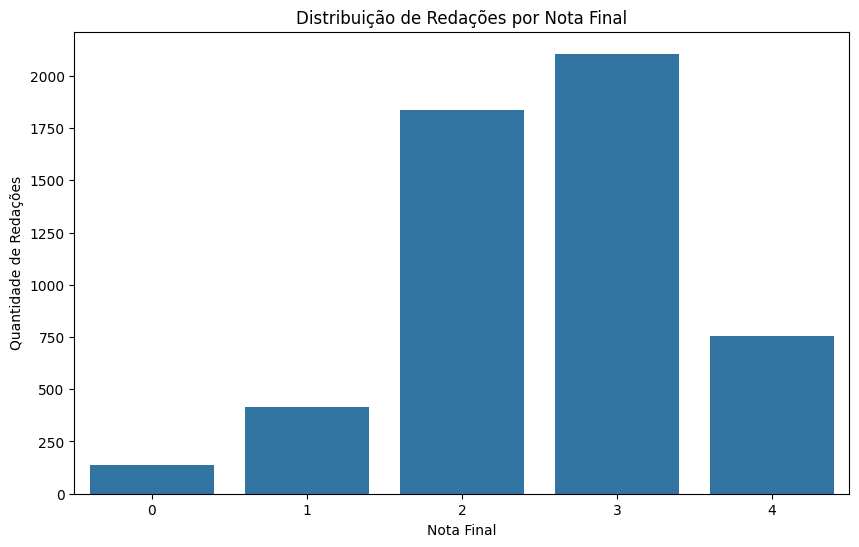

In [29]:
plot_distribution_by_score(X_train_scaled_df)

### SMOTE para o desbalanceamento de classes

In [ ]:
# Aplicar SMOTE para balancear as classes
smote = SMOTE(random_state=42)
X_train_smote, y_train_smote = smote.fit_resample(X_train_scaled, y_train)

# Confirmar a distribuição de classes após SMOTE
print("Distribuição de classes após SMOTE no conjunto de treino:")
print(y_train_smote.value_counts())

X_train_smote_df = pd.DataFrame(X_train_smote, columns=X.columns)
X_train_smote_df['target'] = y_train_smote.values

X_train_smote_df.to_csv('../data/features/essay_train_smote.csv', index=False)

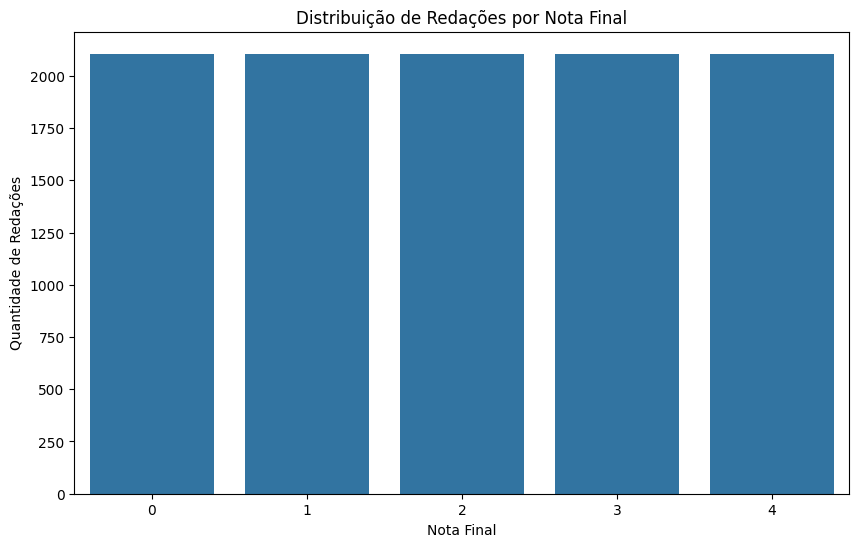

In [31]:
plot_distribution_by_score(X_train_smote_df)

### Carregando o dataset

In [12]:
TRAIN_PATH = "../data/features/essay_train_smote.csv"
TEST_PATH = "../data/features/essay_test_scaled.csv"

train_data = pd.read_csv(TRAIN_PATH)
test_data = pd.read_csv(TEST_PATH)
test_data

,adapted_dalechall,adverbs_before_main_verb_ratio,brunet_indice,clauses_per_sentence,cncadc,cncadd,cncall,cncalter,cnccaus,cnccomp,...,wrdprp1p,wrdprp1s,wrdprp2,wrdprp2p,wrdprp2s,wrdprp3p,wrdprp3s,wrdverb,yule_k,target
0,-1.347021,-0.472203,0.515769,-0.601238,0.484122,2.789352,2.585322,-0.951121,0.399652,-0.029367,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,0.682136,-0.097384,2
1,2.198038,-0.094002,-0.845537,2.297294,-1.104210,-0.358636,-0.660713,-0.951121,-0.723540,-1.163243,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-1.136700,-0.453588,2
2,-0.748844,-0.158640,0.694646,-0.553634,0.484122,1.215358,1.165182,-0.276757,0.175013,0.650958,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,1.028580,0.090033,3
3,-0.273935,-0.708062,-0.519672,-0.262723,0.484122,-0.183748,-0.052081,-0.951121,-0.498902,-0.709693,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.703644,-0.278633,3
4,0.741819,1.049592,-1.005242,-0.169632,-1.104210,-0.008859,-0.457836,0.397606,-0.948178,-0.936468,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.876866,-0.294454,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1308,-0.289360,1.037161,-0.970195,-1.141921,-0.310044,0.166029,-0.254958,-0.951121,-0.723540,-0.936468,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.703644,-0.538463,3
1309,0.093935,1.931319,-0.538516,-0.844545,-1.104210,-0.708412,-0.863590,-0.951121,0.399652,0.650958,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.270588,-0.473280,3
1310,-0.486612,-0.481830,0.578151,0.371992,-0.310044,-0.708412,-0.863590,-0.276757,0.848928,0.650958,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,0.335691,-0.126376,2
1311,-0.499639,-0.946864,0.195966,-0.355815,-1.104210,0.340917,-0.254958,0.397606,0.624290,0.650958,...,-0.181715,-0.084029,-0.128131,-0.034467,-0.124436,-0.456054,-0.469185,-0.443810,0.305634,4


## Treinando com Modelos


Primeiramente, escolhemos treinar 3 modelos "caixa preta", que apriore não possuem uma fácil interpretabilidade, mas tendem a ter uma perfamance significativamente melhor são eles Random Forest, Support Vector Machines e Logistic Regression. Depois disso, utilizaremos o modelo Decision Tree a fim de interpretar as saídas do melhor modelo de acordo com a métrica quadratic kappa, amplamente utilizada na avaliação de modelos de geração de pontuação automática de redação.

In [13]:
feature_names = train_data.columns[:-1]
class_names = [0, 0.5, 1., 1.5, 2.]

X_train = train_data.loc[:, feature_names].to_numpy()
Y_train = train_data.target.to_numpy()

X_test = test_data.loc[:, feature_names].to_numpy()
Y_test = test_data.target.to_numpy()

In [14]:
rf_clf = RandomForestClassifier(max_depth=12, random_state=0).fit(X_train, Y_train)
svc_clf = SVC(kernel="linear", C=0.025).fit(X_train, Y_train)
lr_clf = LogisticRegression(random_state=0).fit(X_train, Y_train)
clf_list = [svc_clf,rf_clf,lr_clf ]

/opt/conda/envs/aibox-env/lib/python3.10/site-packages/sklearn/linear_model/_logistic.py:458: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(


In [15]:
def compute_metrics(models_list, x_test, y_test, metric_dict = {
        "cohen_kappa_score": {"weights":"quadratic"}
    }):

    """
    Computa as métricas relacionadas ao smodelos retornando um dataframe pandas com o nome do 
    modelo a métrica e valor.
    models_list: list de modelos a serem avaliados
    x_test: conjunto de teste
    y_test: classes alvo 
    metric_dict: dicionário com métrica e parametros
    """

    report = defaultdict(list)
    metric_names = list(metric_dict.keys())
    for clf in models_list:
        y_hat = clf.predict(x_test)
        for metric in metric_names:
            score = getattr(metrics, metric)(y_hat, y_test, ** metric_dict[metric])
            report[clf.__class__.__name__].append(score)

    return pd.DataFrame.from_dict(report, orient='index', columns=metric_names).round(3)

### Analise dos Resultados

A métrica Quadratic Kappa é utilizada para avaliação de redações em diferentes trabalhos para mineração de dados educacionais [[2]](https://journals-sol.sbc.org.br/index.php/rbie/article/view/2869/2211). A métrica varia entre -1 (pior valor) e + 1 melhor valor e mede o nível de concordância entre dois anotadores em relação a uma métrica comum, nesse caso, a nota do aluno. Dessa forma, comparamos a nota fornecida por cada um dos modelos pela nota original dos anotadores. Assim, podemos concluir que o melhor modelo nesse contexto é o Random Forest que obtem um resultado de 0.513 contra 0.431 do Logistic Regression e 0.420 do Support Vector Machines.

In [16]:
result = compute_metrics(clf_list, X_test, Y_test)
result

,cohen_kappa_score
SVC,0.420
RandomForestClassifier,0.513
LogisticRegression,0.431


In [17]:
# Gerar e plotar a matriz de confusão de forma mais visual
def plot_confusion_matrix(clf, x_test, y_test):

    y_hat = clf.predict(x_test)
    conf_matrix = metrics.confusion_matrix(y_test, y_hat)

    # Plotar a matriz de confusão com heatmap
    labels = ['0', '0.5', '1', '1.5', '2']
    plt.figure(figsize=(8, 6))
    sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', cbar=False,
                xticklabels=labels,
                yticklabels=labels)
    plt.xlabel('Predito')
    plt.ylabel('Real')
    plt.title(f'Matriz de Confusão - {clf.__class__.__name__}')
    plt.show()

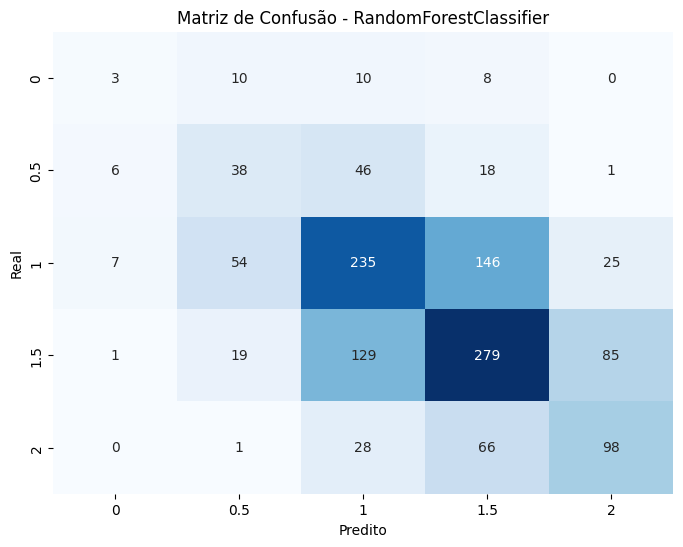

In [18]:
plot_confusion_matrix(rf_clf, X_test, Y_test)

Através da matrix de confusão podemos verificar a distribuição dos acertos do modelo em relação a classe a ser predita. Nele podemos ver que o modelo tem mais facilidade em acerta classes 1 e 1.5 (com maiores exemplos) do que as classes sub-representadas como 0 e 2.

## Explicabilidade

### Explicabilidade Global

#### Global Surrogates

Global Surrogates é uma forma de explicabilidade que usa um modelo caixa branca, explicável para entender as saídas de um modelo caixa preta (não explicável).
É uma tentativa de obter uma explicação geral sobre o resultado final do modelo ao invés de explicar apenas uma saída.

No nosso caso, iremos utilizar o modelo Decision tree, caixa branca, para tentar explicar as saídas dos modelos caixa preta nesse caso o Random Forest.

In [19]:
def plot_tree(dt_clf):
    tree.plot_tree(dt_clf, feature_names = feature_names, 
                    class_names=[str(cls_name) for cls_name in class_names], filled = True)
    
    n_nodes = dt_clf.tree_.node_count
    children_left = dt_clf.tree_.children_left
    children_right = dt_clf.tree_.children_right
    feature = dt_clf.tree_.feature
    threshold = dt_clf.tree_.threshold
    values = dt_clf.tree_.value

    node_depth = np.zeros(shape=n_nodes, dtype=np.int64)
    is_leaves = np.zeros(shape=n_nodes, dtype=bool)
    stack = [(0, 0)]  # start with the root node id (0) and its depth (0)
    while len(stack) > 0:
        # `pop` ensures each node is only visited once
        node_id, depth = stack.pop()
        node_depth[node_id] = depth

        # If the left and right child of a node is not the same we have a split
        # node
        is_split_node = children_left[node_id] != children_right[node_id]
        # If a split node, append left and right children and depth to `stack`
        # so we can loop through them
        if is_split_node:
            stack.append((children_left[node_id], depth + 1))
            stack.append((children_right[node_id], depth + 1))
        else:
            is_leaves[node_id] = True

    print(
        "The binary tree structure has {n} nodes and has "
        "the following tree structure:\n".format(n=n_nodes)
    )
    for i in range(n_nodes):
        if is_leaves[i]:
            print(
                "{space}node={node} is a leaf node with value={value}.".format(
                    space=node_depth[i] * "\t", node=i, value=np.around(values[i], 3)
                )
            )
        else:
            print(
                "{space}node={node} is a split node with value={value}: "
                "go to node {left} if {feature} <= {threshold} "
                "else to node {right}.".format(
                    space=node_depth[i] * "\t",
                    node=i,
                    left=children_left[i],
                    feature=feature_names[feature[i]].upper(),
                    threshold=threshold[i],
                    right=children_right[i],
                    value=np.around(values[i], 3),
                )
            )

Global Sogarrote accuracy:  0.7911878433105576
The binary tree structure has 15 nodes and has the following tree structure:

node=0 is a split node with value=[[ 17. 122. 448. 517. 209.]]: go to node 1 if DESWC <= -0.43910881876945496 else to node 8.
	node=1 is a split node with value=[[ 17. 120. 291.  38.   0.]]: go to node 2 if WRDNOUN <= -1.0545501112937927 else to node 5.
		node=2 is a split node with value=[[ 15. 100.  75.   3.   0.]]: go to node 3 if HAPAX_LEGOMENA <= -1.387585163116455 else to node 4.
			node=3 is a leaf node with value=[[ 5. 60. 13.  0.  0.]].
			node=4 is a leaf node with value=[[10. 40. 62.  3.  0.]].
		node=5 is a split node with value=[[  2.  20. 216.  35.   0.]]: go to node 6 if SYNSTRUTT <= 0.6264251470565796 else to node 7.
			node=6 is a leaf node with value=[[  2.  19. 183.  15.   0.]].
			node=7 is a leaf node with value=[[ 0.  1. 33. 20.  0.]].
	node=8 is a split node with value=[[  0.   2. 157. 479. 209.]]: go to node 9 if DESSC <= 0.407480433583259

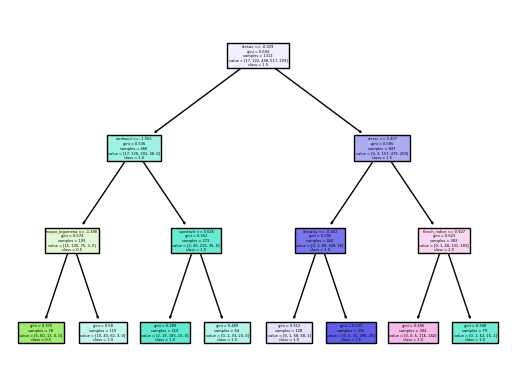

In [20]:
Y_hat = rf_clf.predict(X_test)
dt_clf = DecisionTreeClassifier(max_depth=3).fit(X_test, Y_hat)
Y_hat_dt = dt_clf.predict(X_test)
print("Global Sogarrote accuracy: ", metrics.cohen_kappa_score(Y_hat, Y_hat_dt, weights="quadratic" ))
plot_tree(dt_clf)

##### Análise

Pontos importantes da análise:

- Precisão do Surrogate (Global Sogarrote accuracy: 0.79): A precisão de 79% indica que a árvore de decisão conseguiu capturar uma grande parte do comportamento do modelo original. Ou seja, o modelo surrogate é capaz de prever corretamente a maioria das saídas do modelo caixa preta Random Forest, mas há ainda espaço para melhorias.

- Estrutura da árvore: A árvore começa com um nó que separa os dados com base no valor da variável DESWC (feature do CohMetrix BR - Densidade de palavras coesas). A partir daí, a árvore segue dividindo os dados com base em outros atributos, como WRDNOUN (feature do CohMetrix - Proporção de substantivos), HAPAX_LEGOMENA (feature do lexical_diversity - Mede a proporção de palavras que aparecem apenas uma vez no texto), SYNSTRUTT (feature do CohMetrix - complexidade das sentenças), etc., até chegar nos nós folha.

- Interpretação dos nós: Cada nó de decisão indica uma feature que melhor separa os dados nesse ponto. Por exemplo, o nó 0 utiliza DESWC para decidir se vai para a esquerda ou para a direita. Os valores listados em cada nó representam a distribuição de amostras por classe naquele ponto da árvore. Nós folha mostram as previsões finais feitas pelo modelo de árvore de decisão. Por exemplo, o nó 3 é uma folha onde a maioria das amostras pertence à segunda classe, e o nó 10 mostra que a maioria das amostras pertence à terceira classe.

A árvore é capaz de fornecer insights sobre quais variáveis foram mais importantes para as previsões feitas pelos modelos caixa preta. Por exemplo, variáveis como DESWC, WRDNOUN, HAPAX_LEGOMENA (relacionadas à coesão textual e diversidade lexical) desempenham um papel importante na explicação das previsões do modelo Random Forest.

### LIME

O LIME (Local Interpretable Model-agnostic Explanations) é uma técnica de explicabilidade de modelos que foca em explicar previsões individuais de modelos complexos. Diferente dos surrogates globais, que buscam explicar o comportamento geral de um modelo caixa preta, o LIME gera explicações locais, ou seja, para uma previsão específica.

Ele funciona criando um modelo simples e interpretable (como uma árvore de decisão) que aproxima o comportamento do modelo caixa preta em torno de uma instância individual. O LIME modifica ligeiramente a instância que está sendo explicada, observa como o modelo reage e usa essas informações para construir uma explicação baseada nas features mais relevantes para aquela previsão específica.

In [21]:
sample_class_0 = 328
sample_class_1 = 18
sample_class_2 = 0
sample_class_3 = 9
sample_class_4 = 6

In [22]:
lime_explainer = lime_tb.LimeTabularExplainer(X_train, feature_names =     
                                 feature_names,  class_names=class_names, 
                                 mode = 'classification')

In [23]:
def explain_instance(sample_class_idx):
    predicted_score = rf_clf.predict([X_test[sample_class_idx]])[0]

    lexp = lime_explainer.explain_instance(X_test[sample_class_idx], rf_clf.predict_proba, 
                            num_features=len(feature_names), 
                            labels= (1, predicted_score, ) )
    print("Predicted score", predicted_score)
    print('Document id: %d' % sample_class_idx)
    print('True class: %s' % Y_test[sample_class_idx])
    lexp.as_list()
    
    return lexp, predicted_score
    

def get_the_most_important_features(lexp, predicted_score):
    # Pegando as 10 features mais importantes
    top_k = 10
    exp = lexp.as_list(label=predicted_score)[:top_k]

    # Separando as features e seus valores
    features, values = zip(*exp)

    # Invertendo a ordem para que as mais importantes fiquem no topo
    features = list(features)[::-1]
    values = list(values)[::-1]

    # Plotando o gráfico
    fig, ax = plt.subplots()
    ax.barh(features, values, color=['green' if val > 0 else 'red' for val in values])
    ax.set_xlabel("Feature Contribution")
    ax.set_title(f"Local explanation for class {predicted_score} (Top {top_k} features)")
    plt.show()

Predicted score 0
Document id: 328
True class: 0


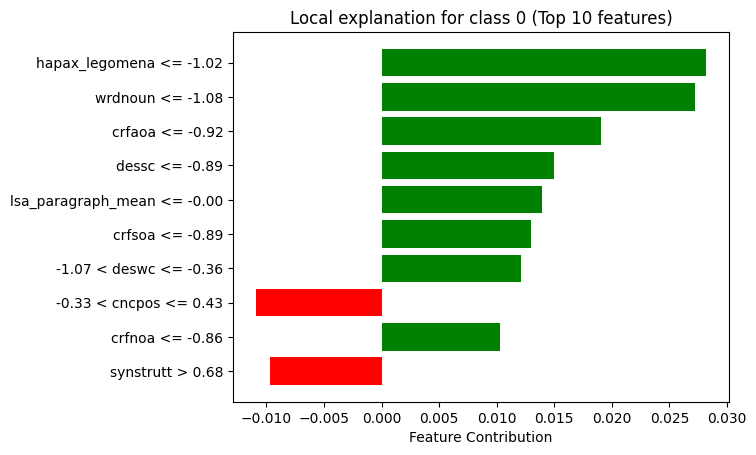

In [24]:
lexp, predicted_score = explain_instance(sample_class_0)
get_the_most_important_features(lexp, predicted_score)

Visualização gerada usando o LIME para a classe 0 (que representa notas entre 0 e 200 pontos no ENEM).

Análise das Features
- wrdnoun <= -1.08 (contribuição positiva): A frequência de substantivos é baixa, o que indica que o texto pode carecer de substantivos essenciais para uma boa construção de ideias. Isso aumenta as chances de o texto pertencer à classe 0.

- hapax_legomena <= -1.02 (contribuição positiva): O valor de hapax legomena (indicador de palavras que aparecem uma única vez no texto) está abaixo de -1.02, sugerindo uma baixa diversidade lexical. Ou seja, textos com pouca variedade de vocabulário são característicos de redações com notas mais baixas (entre 0 e 200).

- despc <= -0.04, crfaoa <= -0.92, dessc <= -0.89 (contribuições positivas): Essas features são relacionadas à coesão, simplicidade textual e organização de ideias. Valores baixos indicam que o texto não tem boa organização ou coesão, contribuindo para uma classificação na faixa mais baixa de pontuação.

- wrdprp1s <= -0.08 e cncpos <= 0.43 (contribuições negativas): Essas duas features possuem contribuições negativas para a classe 0. Isso significa que a presença de pronomes de primeira pessoa singular (provavelmente relacionado ao uso de "eu") e a positividade no tom (coesão positiva) tornam menos provável que o texto caia na classe 0. Esses resultados indicam que textos com uma narrativa mais pessoal e um tom mais positivo estão menos associados às notas mais baixas.

- crfsoa <= -0.89 e outras features relacionadas à coesão: O baixo valor dessa feature sugere que textos com pouca coesão semântica ao longo do texto estão sendo classificados como pertencentes à classe 0. Essa falta de coesão é típica de textos menos desenvolvidos ou mal estruturados.

Predicted score 1
Document id: 18
True class: 1


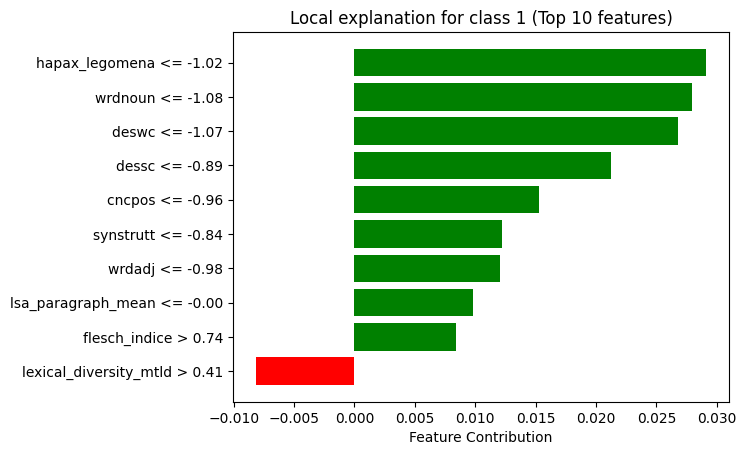

In [25]:
lexp, predicted_score = explain_instance(sample_class_1)
get_the_most_important_features(lexp, predicted_score)

Visualização gerada usando o LIME para a classe 1 (que representa notas entre 201 e 400 pontos no ENEM).

Análise das Features:

- hapax_legomena <= -1.02 (contribuição positiva mais alta): Assim como na classe 0, a baixa diversidade lexical (hapax_legomena) desempenha um papel importante.

- wrdnoun <= -1.08 e deswc <= -1.07 (contribuições positivas): A baixa frequência de substantivos e a baixa coesão textual continuam contribuindo de forma significativa para a previsão da classe 1.

- synstrutt <= -0.84 e wrdadj <= -0.98 (contribuições positivas): A complexidade sintática e o uso de adjetivos também são baixos, contribuindo positivamente para a classe 1. Isso pode indicar que, enquanto o texto está melhor do que na classe 0, ele ainda apresenta dificuldades na variação e uso de construções gramaticais e descritivas.

- cncpos <= -0.96 e outras features: Essas features indicam que o texto ainda está longe de ser coeso ou positivo em seu tom geral, o que sugere que ele pode ser um pouco mais organizado ou claro do que os textos na classe 0, mas ainda apresenta deficiências significativas.

- deswllt <= -0.83 (contribuição positiva): Essa feature, possivelmente relacionada à fluência ou simplicidade textual, contribui positivamente, reforçando a ideia de que o texto classificado na classe 1 pode ser mais simples, sem apresentar grandes variações ou complexidade em sua estrutura.

Predicted score 2
Document id: 0
True class: 2


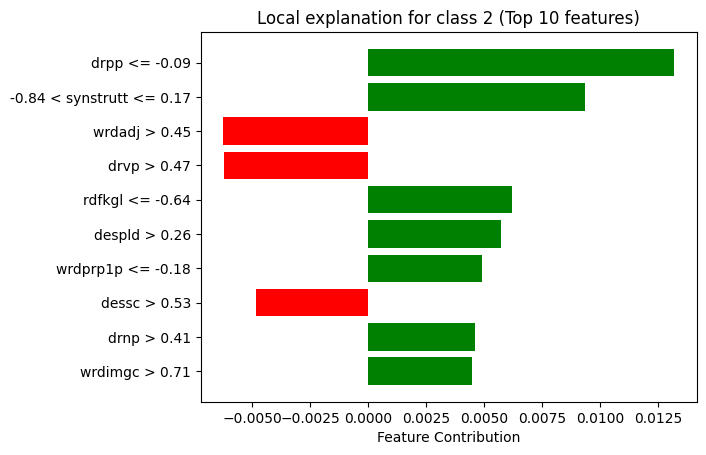

In [26]:
lexp, predicted_score = explain_instance(sample_class_2)
get_the_most_important_features(lexp, predicted_score)

Visualização gerada usando o LIME para a classe 2 (que representa notas entre 401 e 600 pontos no ENEM).

Análise das Features
- despc <= -0.04 (contribuição negativa mais alta): A densidade de conectores pragmáticos (despc) tem a contribuição negativa mais alta. Isso indica que a ausência ou o uso inadequado de conectores pragmáticos, que ligam partes do texto e facilitam a coesão, reduz a probabilidade do texto ser classificado nessa faixa de pontuação.

- -0.84 < synstrutt <= 0.17 (contribuição positiva mais alta): A complexidade sintática (synstrutt) tem uma contribuição positiva significativa. Textos com uma estrutura gramatical mais sofisticada, que incluem sentenças mais complexas, são vistos de forma mais favorável nessa faixa.

- wrdadj > 0.45 e despl > 0.33 (contribuições negativas): 
  - Proporção de adjetivos (wrdadj) aparece com uma contribuição negativa, indicando que o uso excessivo de adjetivos pode prejudicar a avaliação do texto. Isso pode estar relacionado a um estilo descritivo excessivo que, em alguns contextos, pode parecer superficial ou redundante.
  - A densidade de conectores lógicos (despl) também tem uma contribuição negativa. Um alto valor para essa métrica pode indicar o uso excessivo de conectores lógicos, o que pode resultar em um texto que se torna mecânico ou muito explicativo.

- despc2 <= -0.06 e wrdprp1s <= -0.08 (contribuições negativas menores): A segunda densidade de conectores pragmáticos (despc2) e a presença de pronomes de primeira pessoa singular (wrdprp1s) têm contribuições negativas. Isso reforça a ideia de que um texto que usa menos conectores pragmáticos e pronomes pessoais pode ser considerado mais coeso e objetivo.

- flesch_indice > 0.74 (contribuição positiva): O índice de legibilidade de Flesch contribui positivamente, indicando que textos mais fáceis de ler, com frases curtas e palavras simples, são favorecidos.

- cncadd > 0.34 e outras features de coesão: 
 - Coesão aditiva (cncadd) também contribui positivamente. Isso significa que o uso de conectores aditivos (como "e", "além disso") melhora a transição entre ideias no texto, favorecendo sua avaliação.
 - Densidade de substantivos (drnp) e pronomes pessoais (drpp) têm contribuições positivas menores, sugerindo que a presença equilibrada desses elementos melhora a qualidade e a coesão do texto.

Predicted score 3
Document id: 9
True class: 3


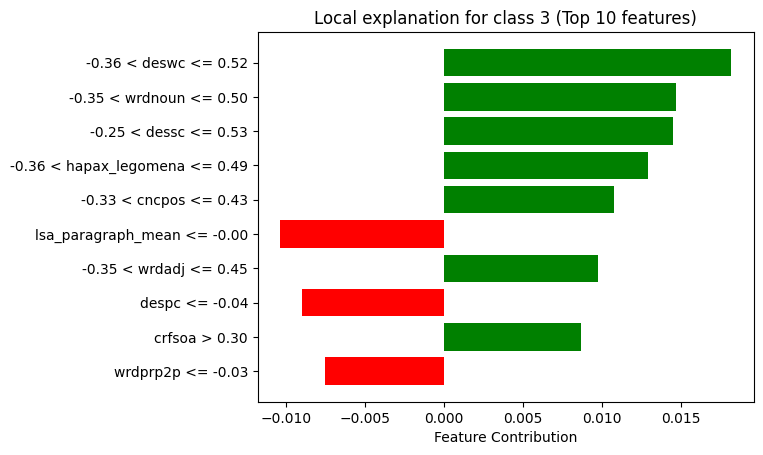

In [27]:
lexp, predicted_score = explain_instance(sample_class_3)
get_the_most_important_features(lexp, predicted_score)

Análise das Features

- wrdnoun <= 0.50 (contribuição positiva mais alta): A presença de substantivos (wrdnoun) é a feature com a maior contribuição positiva. Isso indica que um texto com uma quantidade adequada de substantivos tende a ser bem avaliado. 

- dessc <= 0.53 e deswc <= 0.52 (contribuições positivas): A densidade semântica entre sentenças (dessc) e a densidade de palavras coesas (deswc) têm contribuições positivas significativas. Textos com uma boa coesão semântica e lexical demonstram uma organização clara e coesa entre ideias, o que favorece a compreensão e avaliação do texto. A fluidez e o encadeamento de ideias são altamente valorizados.

- hapax_legomena <= 0.49 (contribuição positiva): A presença de hapax_legomena (palavras que aparecem apenas uma vez) sugere uma maior diversidade lexical. Textos que evitam a repetição excessiva de palavras e apresentam maior variedade no vocabulário tendem a ser bem avaliados, pois demonstram sofisticação e criatividade no uso da linguagem.

- lsa_paragraph_mean <= -0.00 (contribuição negativa mais alta): A coerência semântica entre parágrafos (lsa_paragraph_mean) tem a maior contribuição negativa. Isso indica que o texto apresenta algumas dificuldades em manter a coesão ao longo dos parágrafos, o que pode prejudicar o entendimento geral.

- cncpos <= 0.43, crfnoa > 0.27 e outras features de coesão: Coesão positiva (cncpos) e conectividade referencial (crfnoa e crfaoa) também têm contribuições positivas. Isso sugere que o uso de conectores e pronomes referenciais contribui para a clareza e a coesão textual.

- wrdprp2p <= -0.03 e flesch_indice <= 0.10 (contribuições positivas menores): 
  - A presença de pronomes de segunda pessoa no plural (wrdprp2p) aparece com uma contribuição positiva, indicando que o uso equilibrado desses pronomes pode favorecer a pontuação.
  - Índice de legibilidade de Flesch (flesch_indice) tem uma contribuição positiva, o que indica que textos com uma legibilidade razoável (não muito simples nem muito complexos) são valorizados nessa faixa.

Predicted score 4
Document id: 6
True class: 4


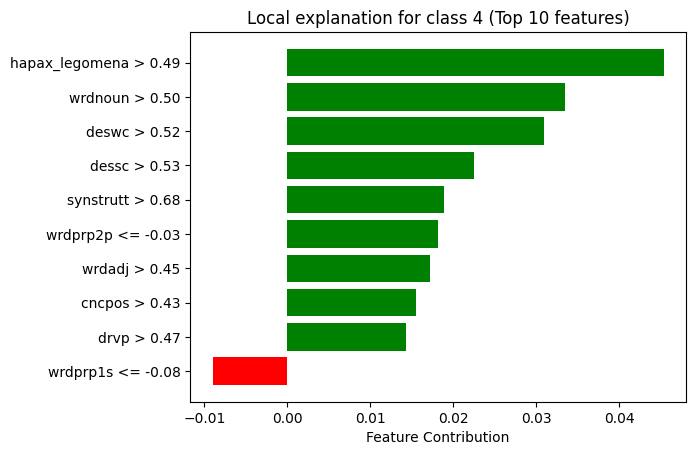

In [28]:
lexp, predicted_score = explain_instance(sample_class_4)
get_the_most_important_features(lexp, predicted_score)

Visualização gerada usando o LIME para a classe 4 (que representa notas entre 801 e 1000 pontos no ENEM).

Análise das Features
- hapax_legomena > 0.49 (contribuição positiva mais alta): A diversidade lexical representada pela presença de hapax legomena (palavras que aparecem apenas uma vez no texto) é a feature com a maior contribuição positiva. Isso indica que textos com um vocabulário diversificado, onde poucas palavras se repetem, são fortemente favorecidos. 

- wrdnoun > 0.50 (contribuição positiva): A frequência de substantivos (wrdnoun) é uma das principais características positivas. Substantivos ajudam a estruturar o conteúdo de forma mais concreta e clara, fornecendo profundidade ao texto. Textos com muitos substantivos tendem a ser mais descritivos e completos, o que é valorizado nas redações de alto desempenho.

- deswc > 0.52 e dessc > 0.53 (contribuições positivas): Densidade de palavras coesas (deswc) e densidade semântica entre sentenças (dessc) têm contribuições positivas substanciais. Textos que mantêm uma boa coesão lexical (entre palavras) e semântica (entre frases) são percebidos como claros e bem organizados.

- wrdadj > 0.45 e wrdprp2p <= -0.03 (contribuições positivas): 
  - A presença de adjetivos (wrdadj) também tem uma contribuição positiva. O uso adequado de adjetivos enriquece o texto, tornando-o mais descritivo e expressivo, o que contribui para uma pontuação mais alta.
  - Pronomes de segunda pessoa do plural (wrdprp2p) têm uma contribuição positiva, indicando que o uso moderado desses pronomes pode aumentar a pontuação, provavelmente ao ajudar na clareza do texto.

- synstrutt > 0.68 e cncpos > 0.43 (contribuições positivas menores):
  - Complexidade sintática (synstrutt) sugere que textos com estruturas gramaticais mais complexas são melhor avaliados. 
  - A coesão positiva (cncpos) também desempenha um papel importante.

- drvp > 0.47 e despc <= -0.04 (contribuições menores):
  - A frequência de verbos principais (drvp) tem uma contribuição positiva, indicando que o uso adequado de verbos de ação ajuda na clareza e dinamismo do texto.
  - Por outro lado, a densidade de conectores pragmáticos (despc) tem uma pequena contribuição negativa. Isso pode sugerir que o uso excessivo de conectores pragmáticos, como "portanto", "no entanto", pode tornar o texto mecânico ou excessivamente didático, prejudicando sua fluidez.

In [29]:
lexp.show_in_notebook( labels= (predicted_score, ))

### Force Plot Shap


Force Plot do Shap permite que visualizemos como determinadas características impactam positivamente ou negativamente na predição de cada classes. O valor base 0.19999 é media de todas as predições enquanto as barras vermelhas (valores que influencia positivamente) e azul (negativamente) "empurram" a predição para longe do valor base esperado.

In [30]:
import shap
import matplotlib.pyplot as plt

# load JS visualization code to notebook
shap.initjs()

# Create the explainer
shap_explainer = shap.TreeExplainer(rf_clf)

shap_values = shap_explainer.shap_values(X_test)

In [31]:
instance_idx = sample_class_4 
figure = plt.figure()
pred_idx = rf_clf.predict([X_test[instance_idx]])[0]
class_idx = Y_test[instance_idx]
print("Instance index: ", instance_idx)
print("Predicted value: ", class_names[pred_idx])
print("True Value: ", class_names[class_idx])
shap.plots.force(shap_explainer.expected_value[0], shap_values[instance_idx,:,pred_idx], X_test[instance_idx], feature_names = feature_names)

Instance index:  6
Predicted value:  2.0
True Value:  2.0


<Figure size 640x480 with 0 Axes>

Como podemos análisar na imagem a cima, o exemplo tem como classe predita e verdadeira a classe 2 que representa redações com nota entre 800-1000. É importante notar que nesse caso, as características como o uso de adverbios e adjetivos para coesão do texto (deswc), o uso depalavras que aparecem apenas umas (hapax_legomena), e a variedade de substantivos (wrdnoun) tem um papel preponderante na classificação da redação como pertencendo a classe 2. Portanto, redações que tem um maior uso de palavras que parecem apenas uma vez, uma boa variaedade de substantivos e o uso de adverbios e adjetivos para manter a coesão narrativa do texto tem uma boa chance de ter notas maiores. 

### Feature Importance Plot 

Com a biblioteca Shap podemos análisar quais características são mais relevantes para predição de cada classe. No nosso caso, escolhemos analisar 100 exemplos do conjunto de teste e avaliar as características são mais relevantes. Limitamos a quantidade de exemplos devido ao tempo de processamento elevado. Ainda sim, podemos ver como características são realçadas de acordo com a classe. Na imagem, as características mais relevantes ficam no top e obtem valores maiores e menos relevantes ficam em baixo e tem valores menores.

Feature Importance Plot - Global Interpretation
Classe avaliada:  2.0


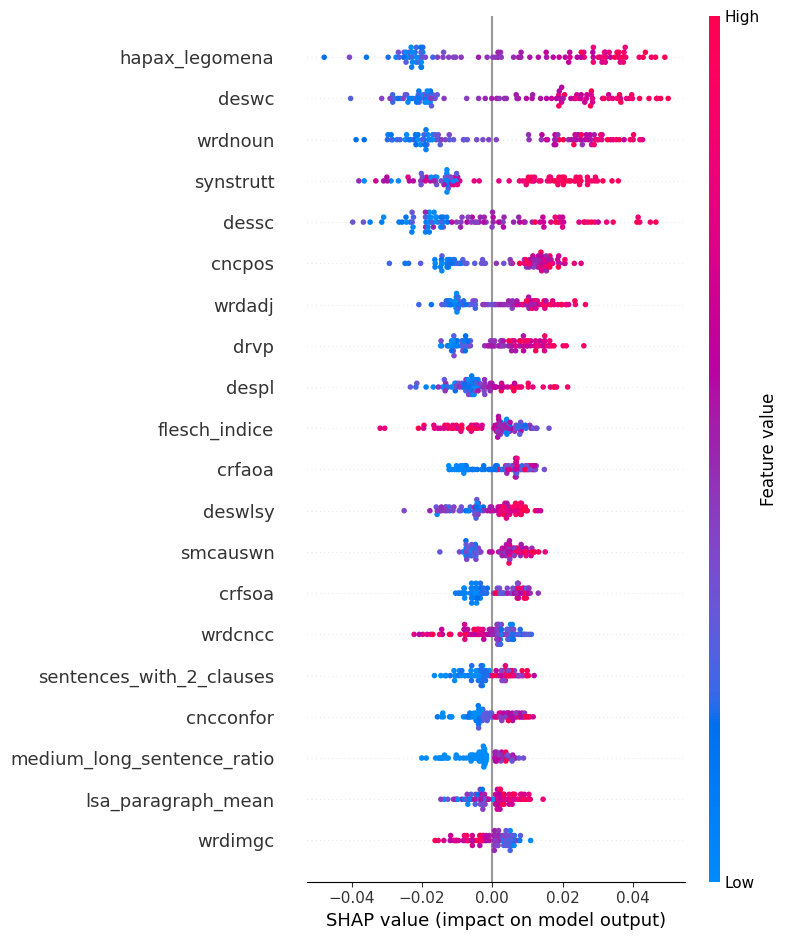

In [32]:
SAMPLE_SIZE = 100

figure = plt.figure()

print("Feature Importance Plot - Global Interpretation")
print("Classe avaliada: ", class_names[class_idx])
shap.summary_plot(shap_values[:SAMPLE_SIZE,:,class_idx], X_test[:SAMPLE_SIZE], feature_names=feature_names)

Assim como mostrado anteriormente com a biblioteca LIME as características relacionadas ao uso de palavras raras (hapax_legomena), a coesão do texto (deswc), bem como, o uso de substantivos continuam sendo atributos que influenciam significativamente na nota do aluno.

### Partial Dependence Plot (PDP)


Partial Dependence Plot (PDPs) nos ajudam a entender a intereção entre duas características em relação a saída. No nosso contexto, podemos analisar como as duas principais características, 'hapax_legomena' e 'deswc', na predição da classe 2 que representa as notas entre valores 800-1000.

In [33]:

X_sample = X_test[:SAMPLE_SIZE]
MAIN_FEATURES = ['hapax_legomena', 'deswc']
feat_idx1, feat_idx2 = np.where( np.isin(feature_names, np.array(MAIN_FEATURES)) )[0]
feat_idx1, feat_idx2

(43, 61)

Variable Importance Plot - Global Interpretation


<Figure size 640x480 with 0 Axes>

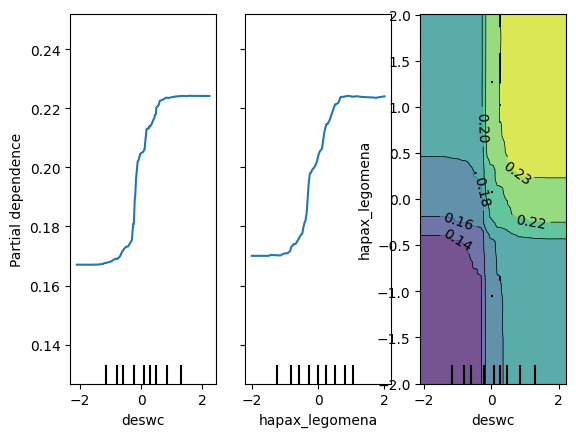

In [34]:
import matplotlib.pyplot as plt
from sklearn.inspection import PartialDependenceDisplay
print("Variable Importance Plot - Global Interpretation")
figure = plt.figure()
features = [feat_idx1, feat_idx2, (feat_idx1, feat_idx2)]
PartialDependenceDisplay.from_estimator(rf_clf, X_sample,
 features, target=Y_test[instance_idx], feature_names=feature_names)

#### Análise Partial Dependece Plot 


Como definido nas celulas anteriores, estamos analisando a instância 6 que obteve uma nota entre 800-1000 (acima da média) ficando com a classe 2. A instância é interessante pelo fato do modelo prever corretamente a nota obtida o que nos ajuda na análise. 
Podemos ver, dessa forma, que duas características extraída fornecidas pelo lexicalDiversityBR e Coh-Metrix e extraídas pela biblioteca aibox-nlp se destacaram como sendo mais influentes para predição da referida classe: [*hapax_legomena*](http://fw.nilc.icmc.usp.br:23380/metrixdoc) e [*deswc*](https://link.springer.com/content/pdf/10.3758/BF03195564.pdf). A característica hapax_legomena computa o aparecemento de palavras raras usadas no texto, computando as palavras que aparecem uma única vez.  Enquanto isso a característica *deswc* avalia o uso de adverbios e adjetivos que poderiam indicam um texto mais descritivo e com mais detalhes, portanto, mais coeso. Como podemos analisar na imagem acima, quando ambas métricas tem um alto valor e isso influencia para que a nota predita também seja alto, ou seja, uma redação com alto valor de palavras raras (que aparecem uma única vez, *hapax_legomena* ) e alto valor descritivo (*deswc*) tende a ter uma nota entre os valores 800-1000.

*A descrição da característica deswc foi obitida junto ao GPTo-mini
